In [1]:
import os
import sys
import time
import glob
import io
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import layoutparser

In [2]:
nb_dir = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
from src.utilities.primalaynet.infer import draw_box
app_context.init()
app_context.application_context = dict({'task_id': 'BM-DUMMY'})

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH = "/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_mlt_25k.pth"
config.CRAFT_REFINE_MODEL_PATH  = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth' 


from src.services.main import generate_response,break_blocks,merge_vertically,merge_horizontally,extract_images_and_text_regions

/home/dhiraj/py_envs/bm/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


[2021-04-10 19:46:21,017] {geos.py:73} MainThread DEBUG in geos: Found GEOS DLL: <CDLL '/home/dhiraj/py_envs/bm/lib/python3.6/site-packages/shapely/.libs/libgeos_c-a68605fd.so.1.13.1', handle 5725f20 at 0x7f5de039c278>, using it.
[2021-04-10 19:46:21,044] {geos.py:38} MainThread DEBUG in geos: Trying `CDLL(libc.so.6)`
[2021-04-10 19:46:21,048] {geos.py:55} MainThread DEBUG in geos: Library path: 'libc.so.6'
[2021-04-10 19:46:21,049] {geos.py:56} MainThread DEBUG in geos: DLL: <CDLL 'libc.so.6', handle 7f5e7cb08000 at 0x7f5de039c4e0>
Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [3]:
import layoutparser as lp
model_primalaynet = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"},extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])


In [4]:
def draw_box(filepath,desired_width, desired_height,save_dir, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    if type(df) is list:
        for i in df:
            for index, row in i.iterrows():
                left   = int(row['text_left'])
                right  = int(row['text_width'] + left)
                top    = int(row['text_top'])
                bottom = int(row["text_height"] + top)
                draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    else:

        for index, row in df.iterrows():
            left   = int(row['text_left'])
            right  = int(row['text_width'] + left)
            top    = int(row['text_top'])
            bottom = int(row["text_height"] + top)
            draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    save_filepath = os.path.join(save_dir, os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

In [5]:
#dir which contains the pdf file
input_dir = '/home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/'
#filename = 'footer_test.pdf'
#filename  = 'grade7-review2timetable.pdf'
#filename = '20695.pdf'
#filename = 's2_en.pdf'
#filename = 'scan_1.pdf'
#filename = 'ncert.pdf'
filename = 'p_df_error.pdf'
lang     = 'en'

In [6]:
[pdf_data,flags] = extract_images_and_text_regions(filename, input_dir,lang,page_layout='single_column')
[pdf_data,flags] = merge_horizontally([pdf_data,flags])
[pdf_data,flags] = merge_vertically([pdf_data,flags])
[pdf_data,flags] = break_blocks([pdf_data,flags])
#response        = generate_response([pdf_data,flags])

[2021-04-10 19:46:26,393] {loghandler.py:21} MainThread INFO in loghandler: document preprocessing started ===>
[2021-04-10 19:46:26,398] {loghandler.py:21} MainThread INFO in loghandler: created processing directories successfully /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/p_df_error_560b8e90-9a07-11eb-92f7-eb8704f9d90e
[2021-04-10 19:46:26,408] {loghandler.py:21} MainThread INFO in loghandler: filepath /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/p_df_error.pdf, working_dir /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/p_df_error_560b8e90-9a07-11eb-92f7-eb8704f9d90e
[2021-04-10 19:46:34,716] {loghandler.py:21} MainThread INFO in loghandler: Extracting xml of /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/p_df_error.pd

ppppppppppagedf  3 1
  index xml_index text_top text_left text_width text_height  \
0   NaN         0      112       162        622         272   
1    11        11      413       162        623          17   
2    12        14      436       162        622          17   
3   NaN        16      459       162        622          87   
4   NaN        21      552       162        621          40   
5   NaN        24      622       162        623         587   

                                                text font_size  \
0  solutions and actors, enabling wide access whi...        16   
1  This is where NDEAR comes in — a  National Dig...        16   
2  create a    ‘Unifying national digital infrast...        16   
3  ecosystem’ .   Essentially,   this   is   a   ...        16   
4  education ecosystem. It is a  ‘distributed, ad...        16   
5  The NDEAR vision, objectives, principles and i...        16   

      font_family font_color attrib font_family_updated font_size_updated 

ppppppppppagedf  5 2
  index xml_index text_top text_left text_width text_height  \
0     0         0      538       135        232          23   
1   NaN         1      568       162        621          63   
2     4         4      637       189        596          17   
3   NaN         9      661       189        596         271   
4    17        27      939       189        596          17   
5   NaN        32      962       189        596         247   

                                                text font_size  \
0                          4. NDEAR - who is it for?        22   
1  The applicability of NDEAR must be viewed in l...        16   
2  ● 5 key personas  -  learners, parents, teache...        16   
3  The term personas mentioned here refers to rol...        16   
4  ● 3 Generalised Scenarios   -   Learn - Help L...        16   
5  whole   education   ecosystem,   three   main ...        16   

      font_family font_color attrib font_family_updated font_size_updated 

5                16  {"index":{"20":20,"21":21,"22":22,"23":23,"24"...  
ppppppppppagedf  13 4
  index xml_index text_top text_left text_width text_height  \
0     0         0      108       189        305          27   
1   NaN         1      148       162        623         248   
2    12        16      426       189        566          27   
3   NaN        17      465       162        622         179   
4    19        24      651       162        116          17   
5   NaN        27      674       162        623         535   

                                                text font_size  \
0                a. Focus on Beneficiaries and Users        21   
1  User-Centric Design : In the development of in...        16   
2  b. Ecosystem Approach - Participation, Collabo...        21   
3  “Ecosystem” – and NOT a “System” has been echo...        16   
4                               Energise  across  :         16   
5  ● Actors -   G overnment + Civil Society (comm...        16   



ppppppppppagedf  19 2
  index xml_index text_top text_left text_width text_height  \
0     0         0      108       189        392          27   
1   NaN         1      151       162        622         201   
2     9         9      376       162        159          17   
3   NaN        10      422       162        623         787   

                                                text font_size  \
0      b. Federated Architecture and Building Blocks        21   
1  NDEAR provides an approach to establish a “Fed...        16   
2                             Federated Architecture        16   
3  Federated   architecture   (FA)   is   a   pat...        16   

              font_family font_color attrib font_family_updated  \
0  FAAAAA+Rajdhani-Medium    #000000            Rajdhani-Medium   
1          CAAAAA+Carlito    #000000    NaN             Carlito   
2          BAAAAA+Carlito    #000000   BOLD             Carlito   
3          CAAAAA+Carlito    #000000    NaN             Carlito

ppppppppppagedf  23 3
  index xml_index text_top text_left text_width text_height  \
0   NaN         0      112       162        622         179   
1     8         8      320       162         87          17   
2   NaN         9      343       162        623         249   
3    19        20      622       162         59          17   
4   NaN        21      645       162        622          63   
5    23        24      737       162         65          17   
6   NaN        25      761       162        622          63   
7    27        28      853       162        141          17   
8   NaN        29      877       162        623         332   

                                                text font_size  \
0  the vision of NDEAR and also to set up demonst...        16   
1                                        Governance:        16   
2  PMU shall initially work directly under the Mi...        16   
3                                           Funding:        16   
4  PMU shall be s

ppppppppppagedf  26 1
  index xml_index text_top text_left text_width text_height  \
0   NaN         0      112       162        622         121   
1     5         5      258       162        382          17   
2   NaN         6      278       162        622         272   
3    16        16      579       162        268          17   
4   NaN        17      618       162        622         444   
5   NaN        32     1086       162        621          51   
6    34        34     1192       768         17          17   

                                                text font_size  \
0  engaged, happy, confident and thinking critica...        16   
1  Building Blocks for Foundational Literacy and ...        16   
2  In   light  of  the  goals,  objective  and   ...        16   
3              Suggested application of NDEAR to FLN        16   
4  The priorities for FLN are stated in the goals...        16   
5  An illustrative exercise of some of the buildi...        19   
6          

ppppppppppagedf  31 0
  index xml_index text_top text_left text_width text_height  \
0     0         0      199       135        339          23   
1   NaN         2      229       189        593          44   
2   NaN         4      297       162        622         320   
3   NaN        16      641       189        593          43   
4   NaN        18      708       162        622         253   
5    27        28      985       189        495          17   
6   NaN        29     1026       162        623         183   

                                                text font_size  \
0                   12. Questions and clarifications        22   
1  a. How does NDEAR differ  from any  technology...        16   
2  NDEAR is not a project where the Government wi...        16   
3  b. Would NDEAR be about centralisation and the...        16   
4  NDEAR   is   not   a   control-oriented,   cen...        16   
5  c. How will NDEAR ensure the protection of chi...        16   
6  In conso

[2021-04-10 19:47:10,302] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.12138485908508301/1, average per page 0.12138485908508301
[2021-04-10 19:47:10,398] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.0790245532989502/1, average per page 0.0790245532989502
[2021-04-10 19:47:10,461] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.05518627166748047/1, average per page 0.05518627166748047
[2021-04-10 19:47:10,536] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.05652260780334473/1, average per page 0.05652260780334473
[2021-04-10 19:47:10,601] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.04852008819580078/1, average per page 0.04852008819580078
[2021-04-10 19:47:10,645] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.03395509719848633/1, average

[2021-04-10 19:47:15,246] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.0632174015045166/1, average per page 0.0632174015045166
[2021-04-10 19:47:15,352] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.07573175430297852/1, average per page 0.07573175430297852
[2021-04-10 19:47:15,446] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.06962466239929199/1, average per page 0.06962466239929199
[2021-04-10 19:47:15,514] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.05249810218811035/1, average per page 0.05249810218811035
[2021-04-10 19:47:15,714] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.15575480461120605/1, average per page 0.15575480461120605
[2021-04-10 19:47:15,916] {loghandler.py:21} MainThread INFO in loghandler: Processing of get_hdfs completed in 0.18019628524780273/1, average

In [7]:
#pdf_data

In [8]:
flags

{'doc_class': 'class_1', 'page_layout': 'double_column'}

In [9]:
# width_ratio = pdf_data['page_width'] / pdf_data['pdf_image_width']
# height_ratio = pdf_data['page_height'] / pdf_data['pdf_image_height']
# predict_primanet(img_filepath,pdf_bg_img_filepaths,to_check[0],width_ratio,height_ratio)

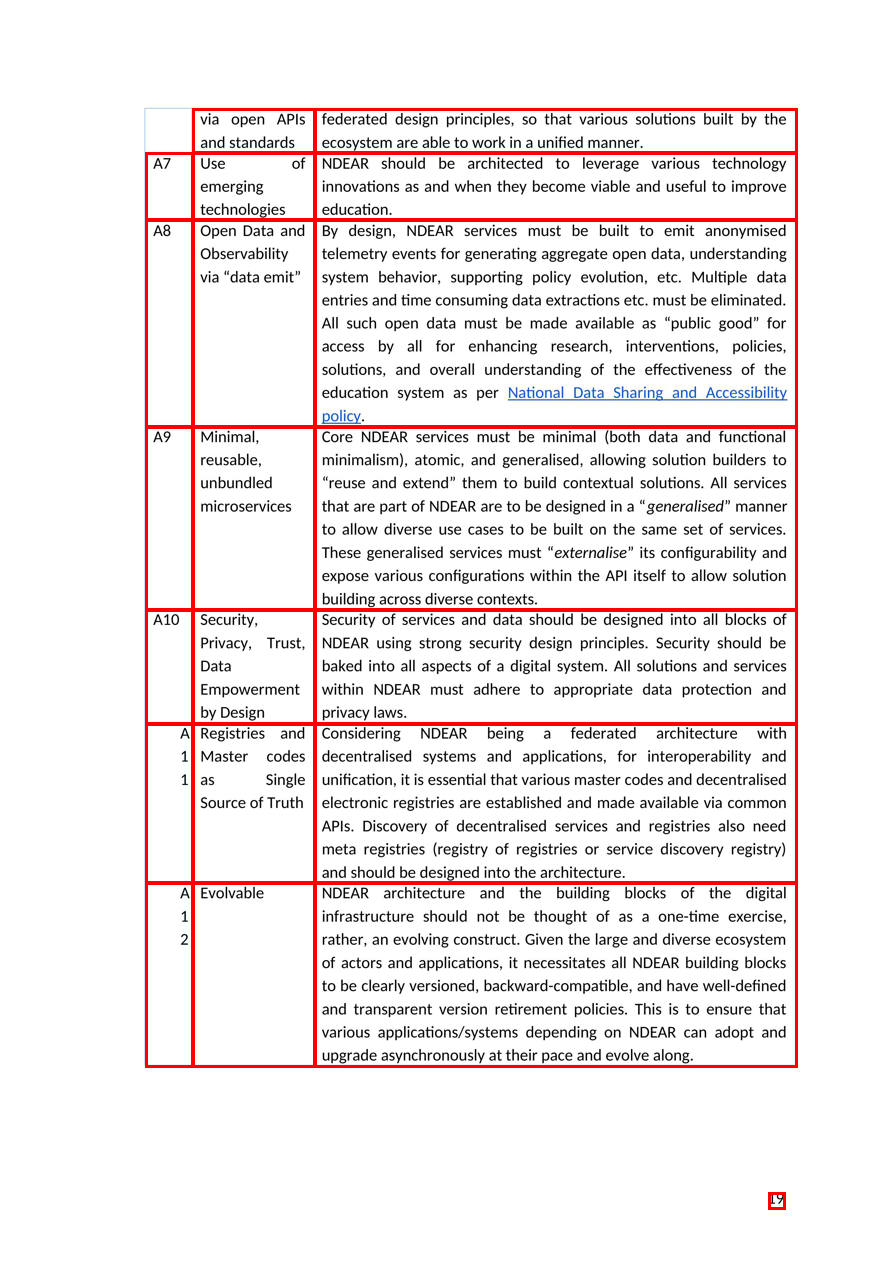

In [13]:
page_index = 18
to_check        = pdf_data['p_dfs']
#to_check_in_df        = pdf_data['v_dfs'][page_index]
img_filepath    = pdf_data['pdf_image_paths'][page_index]
pdf_bg_img_filepaths  = pdf_data['pdf_bg_img_filepaths'][page_index]
df              = to_check[page_index]

desired_width, desired_height = pdf_data['page_width'] , pdf_data['page_height']
draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)

In [11]:
df

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,font_family_updated,font_size_updated,children
82,82,1192,768,17,17,19,16,CAAAAA+Carlito,#000000,,Carlito,16,None


In [12]:
for i in to_check_in_df['children']:
    d =pd.read_json(i)
    print(d)
    print(d['children'])

NameError: name 'to_check_in_df' is not defined

In [ ]:
import numpy as np
p_df_image = draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)
sc_pdf_image = draw_box(img_filepath,desired_width, desired_height, 'path',to_check_in_df, color="red", save=False)
stiched_imag = np.hstack([np.array(p_df_image) ,np.array(sc_pdf_image)])
compare_image = Image.fromarray(stiched_imag)
compare_image.save("/home/naresh/1.jpg")

In [ ]:
def predict_primanet(image_path,bg_image_path,in_df,width_ratio,height_ratio):
    image1  = cv2.imread(image_path)
    image2  = cv2.imread(bg_image_path)
    image = image1[..., ::-1] 
    layout = model_primalaynet.detect(image)
    boxes,coords = draw_box(layout, in_df,width_ratio,height_ratio)
    final_coord= []
    for coord in coords:
        temp_dict={}
        temp_dict['text_left']=coord[0]; temp_dict['text_top']=coord[1]
        temp_dict['text_width']=coord[2]; temp_dict['text_height']=coord[3]
        #draw.rectangle(coord, width=3,outline='red')
        final_coord.append(temp_dict)
        cv2.rectangle(image1, (int(coord[0]),int(coord[1])), (int(coord[2]),int(coord[3])),(255,255,0),3)
        cv2.rectangle(image2, (int(coord[0]*width_ratio),int(coord[1]*height_ratio)), (int(coord[2]*width_ratio),int(coord[3]*height_ratio)),(255,255,0),3)

        cv2.imwrite("1.jpg",image1)
        cv2.imwrite("2.jpg",image2)

    return final_coord

In [ ]:
p